In [2]:
from utils.binaries import *

10:07:46 [INFO] utils          -- (<99999ms) -- import logging
10:07:47 [INFO] utils.binaries -- (  +136ms) -- import numpy as np
10:07:47 [INFO] utils.binaries -- (    +6ms) -- import uncertainties
10:07:47 [INFO] utils.binaries -- (  +140ms) -- import pandas as pd
10:07:47 [INFO] utils.binaries -- (    +2ms) -- import binaries.tools as tools


In [8]:
fmt = {
    "wcd": np.dtype(
        [
            ("timestamp", "I"),
            # ('t1_latch_bin', 'h'),
            ("baseline", ("H", 3)),
            ("traces", ("h", (3, 2048))),
        ]
    ),
    "ssd": np.dtype(
        [
            ("timestamp", "I"),
            # ('t1_latch_bin', 'h'),
            ("baseline", "H"),
            ("trace", ("h", 2048)),
        ]
    ),
}


def read(file_path, f) -> np.ndarray:

    # buffer = bz2.BZ2File(file_path).read()
    return np.fromfile(file_path, fmt[f])


with open(
    "/cr/tempdata01/filip/UubRandoms/2023_03/converted/timestamps/Nadia.dat", "w"
) as timestamps:
    for i in tools.ProgressBar(range(1434), newline=False):
        path_to_file = (
            f"/cr/data02/AugerPrime/UUB/UubRandoms/2023_03/Nadia/randoms{i:04}.wcd"
        )
        data = read(path_to_file, "wcd")["timestamp"]
        if len(data) == 0:
            continue

        timestamps.write(
            f"{path_to_file.split('/')[-1]} {int(data.min())} {int(data.max())}\n"
        )

running: 1434/1434 [********************] || 00:05:25>00:00:00,         4.41 it/s


In [10]:
data = np.loadtxt("/cr/data02/AugerPrime/UUB/UubRandoms/t1_rates/Nadia.txt")

with open("/cr/data02/AugerPrime/UUB/UubRandoms/t1_rates/Nadia.txt", "w") as file:
    for row in data:
        t, rate = row
        n = rate * 5000 * 2048 * 8.33e-9

        file.write(f"{int(t)} {int(n)} {rate:.2f}\n")

In [11]:
station = "Nadia"

timestamps, counts, rates = np.loadtxt(
    f"/cr/data02/AugerPrime/UUB/UubRandoms/t1_rates/{station}.txt", unpack=True
)
sort = np.argsort(timestamps)
t1_rates = np.column_stack([timestamps[sort], counts[sort], rates[sort]])
np.savetxt(
    f"/cr/data02/AugerPrime/UUB/UubRandoms/t1_rates/{station}.txt",
    t1_rates,
    fmt="%u %u %.3f",
)

In [12]:
from utils.Auger.SD.UubRandoms import UubRandom

In [16]:
data = np.fromfile(
    "/cr/data02/AugerPrime/UUB/UubRandoms/2023_03/Nadia/randoms0080.ssd",
    UubRandom.fmt["ssd"],
)

Text(0.02, 0.5, 'T1 trigger rate / Hz')

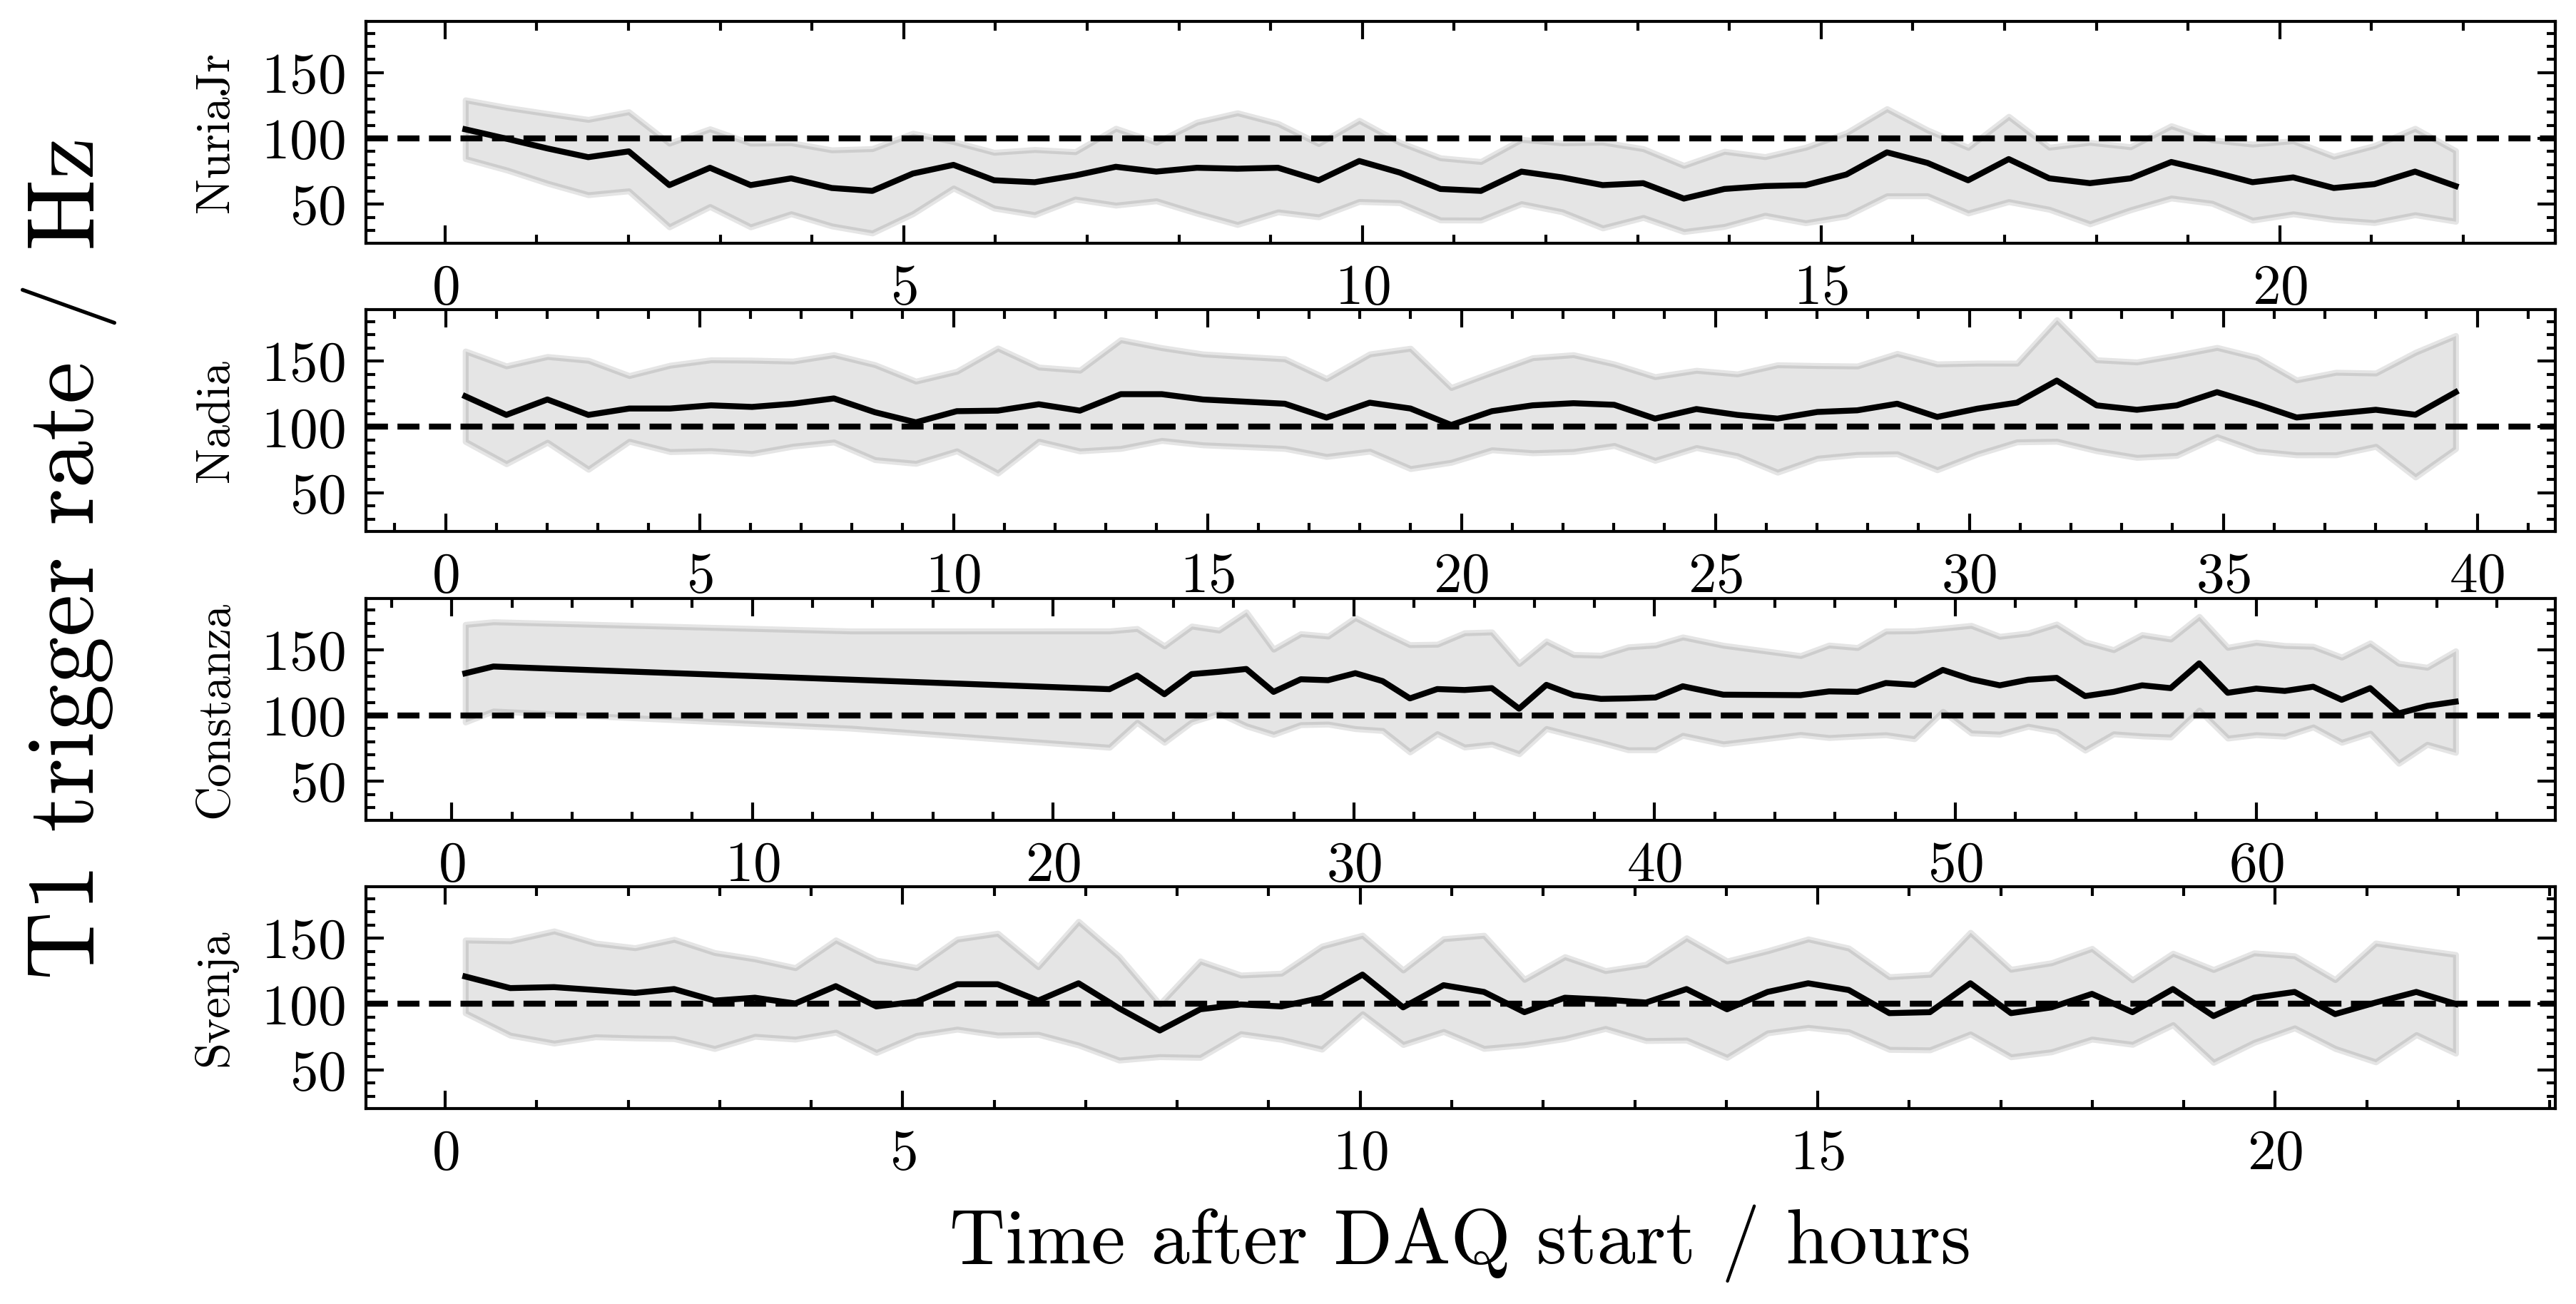

In [6]:
from utils.binaries import *
from utils.plotting import *

from datetime import datetime

fig, axes = plt.subplots(4, 1, sharey=True)

for station, ax in zip(["NuriaJr", "Nadia", "Constanza", "Svenja"], axes):
    t, n, rates = np.loadtxt(
        f"/cr/data02/AugerPrime/UUB/UubRandoms/t1_rates/{station}.txt", unpack=True
    )
    t_binned, rates_binned = np.array_split(t, 50), np.array_split(rates, 50)
    t, rates = np.array([np.mean(tx) - t[0] for tx in t_binned]), np.array(
        [np.mean(rx) for rx in rates_binned]
    )
    rates_error = np.array([np.std(rx) for rx in rates_binned])
    ax.plot(t / 3600, rates, label=station)
    ax.fill_between(
        t / 3600, rates - rates_error, rates + rates_error, color="k", alpha=0.1
    )
    ax.axhline(100, lw=1, ls="--")
    ax.set_ylabel(station, fontsize=8)

ax.set_xlabel("Time after DAQ start / hours")
plt.subplots_adjust(hspace=0.3)
fig.text(
    0.02,
    0.5,
    "T1 trigger rate / Hz",
    rotation=90,
    horizontalalignment="center",
    verticalalignment="center",
    fontsize=16,
)